# Unit 5 - Financial Planning


In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
from currency_converter import CurrencyConverter

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
crypto_bag = [1.2, 5.3]

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
btc_price = btc_data['data']['1']['quotes']['CAD']['price']
# Fetch current ETH price
eth_data = requests.get(eth_url).json()
eth_price = eth_data['data']['1027']['quotes']['CAD']['price']
# Compute current value of my crpto
my_btc_value = btc_price * crypto_bag[0]
my_eth_value = eth_price * crypto_bag[1]
# Print current crypto wallet balance
print(f"The current value of your {crypto_bag[0]} BTC is ${my_btc_value:0.2f} CAD")
print(f"The current value of your {crypto_bag[1]} ETH is ${my_eth_value:0.2f} CAD")

The current value of your 1.2 BTC is $20112.29 CAD
The current value of your 5.3 ETH is $2738.88 CAD


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Current amount of shares
my_spy = 50
my_agg = 200

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = 'v2'
)

In [8]:
# Format current date as ISO format
today = pd.Timestamp('2020-10-19', tz='America/New_York').isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
ticker_data = api.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Preview DataFrame
ticker_data

AGG                                       SPY  \
                             open    high     low    close   volume    open   
time                                                                          
2020-10-19 00:00:00-04:00  117.81  117.87  117.72  117.787  4231106  348.62   

                                                             
                             high     low   close    volume  
time                                                         
2020-10-19 00:00:00-04:00  349.33  341.04  342.02  54462156

In [9]:
# Pick AGG and SPY close prices
agg_close_price = float(ticker_data['AGG']['close'])
spy_close_price = float(ticker_data['SPY']['close'])

In [10]:
c = CurrencyConverter()
agg_close_price_cad = round(c.convert(agg_close_price, 'USD', 'CAD'),2)
spy_close_price_cad = round(c.convert(spy_close_price, 'USD', 'CAD'),2)

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price_cad} CAD")
print(f"Current SPY closing price: ${spy_close_price_cad} CAD")

Current AGG closing price: $157.79 CAD
Current SPY closing price: $458.18 CAD


In [11]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price_cad
my_agg_value = my_agg * agg_close_price_cad
# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f} CAD")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f} CAD")

The current value of your 50 SPY shares is $22909.00 CAD
The current value of your 200 AGG shares is $31558.00 CAD


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
asset_class = ['Crypto', 'Equities']
savings_dict = {
    'total': [round(my_btc_value+my_eth_value,2), round(my_spy_value+my_agg_value,2)]
}

df_savings = pd.DataFrame(savings_dict, index = asset_class)

# Display savings DataFrame
display(df_savings)

,total
Crypto,22851.18
Equities,54467.00


<AxesSubplot:ylabel='total'>

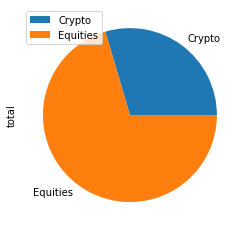

In [13]:
# Plot savings pie chart
df_savings.plot.pie(y='total')

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['total'].sum()

# Validate saving health
if total_savings > emergency_fund:
    print(f'Your savings have surpassed your emergency fund by ${round(total_savings - emergency_fund,2)}')
    print('Keep up the great work!')
elif total_savings == emergency_fund:
    print('Congratulations on building your emergency fund!')
else:
    print(f'You are currently ${round(emergency_fund - total_savings,2)} away from reaching this goal.')
    print('Keep going, you can do this!')

Your savings have surpassed your emergency fund by $41318.18
Keep up the great work!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2015-10-20', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-10-20', tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Display sample data
df_stock_data.head()

AGG                                      SPY  \
                             open    high     low   close   volume    open   
time                                                                         
2015-10-20 00:00:00-04:00  109.64  109.78  109.55  109.65  1672562  202.85   
2015-10-21 00:00:00-04:00  109.73  109.95  109.73  109.89  1119723  203.61   
2015-10-22 00:00:00-04:00  109.90  110.05  109.83  109.94  1817244  202.98   
2015-10-23 00:00:00-04:00  109.79  109.79  109.69  109.74  1344632  207.25   
2015-10-26 00:00:00-04:00  109.85  109.90  109.74  109.79  1385981  207.30   

                                                                
                             high       low   close     volume  
time                                                            
2015-10-20 00:00:00-04:00  203.84  202.5471  203.07   60081395  
2015-10-21 00:00:00-04:00  203.79  201.6500  201.82   83704739  
2015-10-22 00:00:00-04:00  205.51  202.8100  205.22  121670959  
2015-10-23 00:00:00-04:00  207.95  206.3000  207.51  103135843  
2015-10-26 00:00:00-04:00  207.37  206.5600  206.97   51484043

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stocks = MCSimulation(
    portfolio_data=df_stock_data,
    weights = [.40,.60],
    num_simulation=500,
    num_trading_days=252*30
)

In [18]:
# Printing the simulation input data
MC_stocks.portfolio_data.head()

AGG                                   \
                             open    high     low   close   volume   
time                                                                 
2015-10-20 00:00:00-04:00  109.64  109.78  109.55  109.65  1672562   
2015-10-21 00:00:00-04:00  109.73  109.95  109.73  109.89  1119723   
2015-10-22 00:00:00-04:00  109.90  110.05  109.83  109.94  1817244   
2015-10-23 00:00:00-04:00  109.79  109.79  109.69  109.74  1344632   
2015-10-26 00:00:00-04:00  109.85  109.90  109.74  109.79  1385981   

                                           SPY                            \
                          daily_return    open    high       low   close   
time                                                                       
2015-10-20 00:00:00-04:00          NaN  202.85  203.84  202.5471  203.07   
2015-10-21 00:00:00-04:00     0.002189  203.61  203.79  201.6500  201.82   
2015-10-22 00:00:00-04:00     0.000455  202.98  205.51  202.8100  205.22   
2015-10-23 00:00:00-04:00    -0.001819  207.25  207.95  206.3000  207.51   
2015-10-26 00:00:00-04:00     0.000456  207.30  207.37  206.5600  206.97   

                                                   
                              volume daily_return  
time                                               
2015-10-20 00:00:00-04:00   60081395          NaN  
2015-10-21 00:00:00-04:00   83704739    -0.006156  
2015-10-22 00:00:00-04:00  121670959     0.016847  
2015-10-23 00:00:00-04:00  103135843     0.011159  
2015-10-26 00:00:00-04:00   51484043    -0.002602

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stocks.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995005,1.010843,0.994883,1.003685,0.997399,0.992614,0.996789,0.996622,0.996076,1.001985,...,1.008303,0.990837,1.006040,0.991674,0.991712,0.985752,0.997057,1.002660,0.989164,0.995246
2,0.994599,1.013406,0.997007,1.001153,1.002086,0.980566,0.988976,0.996999,0.998391,1.006712,...,1.003257,1.008268,1.002172,0.987035,0.987785,0.988462,0.997368,1.007987,0.989943,1.000488
3,0.982468,1.014700,1.000905,1.001293,0.998697,0.978301,0.977017,0.998963,1.012993,1.011070,...,0.992977,1.012490,1.002974,0.984065,0.984738,0.990086,0.990969,1.006784,0.992543,0.993597
4,0.978963,1.008360,1.007847,1.013776,1.000732,0.973528,0.976050,1.000644,1.018770,1.014758,...,0.993328,1.014359,1.001899,0.976111,0.988789,0.986018,0.997087,1.012778,0.998906,0.995677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,16.591335,9.297295,6.559411,6.859152,24.814381,3.359907,11.298146,9.105430,15.032371,6.455899,...,2.267850,13.831220,32.749668,7.752167,4.193983,7.740496,8.186588,4.552612,8.466614,8.168375
7557,16.469883,9.294237,6.548569,6.881281,24.687725,3.371067,11.350721,9.004045,15.050455,6.435006,...,2.286544,14.008885,33.098143,7.708435,4.195882,7.688450,8.190115,4.535873,8.456711,8.238608
7558,16.496870,9.245750,6.577318,6.822272,24.813534,3.353495,11.311204,8.984249,15.031191,6.489584,...,2.282427,13.902054,33.067959,7.694162,4.218614,7.690023,8.368019,4.554428,8.433879,8.289766
7559,16.505663,9.217922,6.617545,6.808448,24.742921,3.365095,11.314391,8.851897,14.888455,6.636018,...,2.264037,13.888351,32.958061,7.660429,4.246279,7.670547,8.349672,4.564151,8.410454,8.223113


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

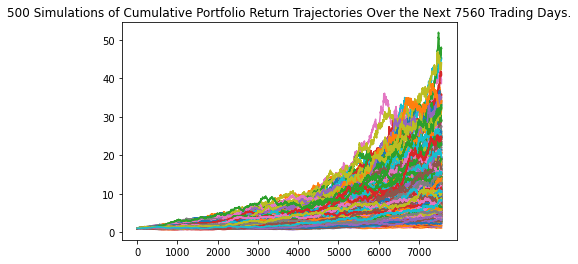

In [20]:
# Plot simulation outcomes
MC_stocks.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

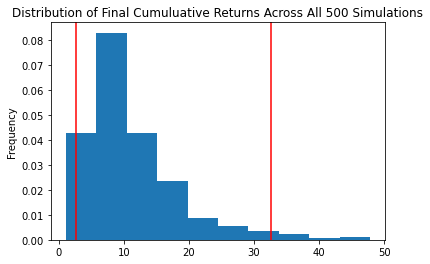

In [21]:
# Plot probability distribution and confidence intervals
MC_stocks.plot_distribution()

### Retirement Analysis

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
stocks_tbl = MC_stocks.summarize_cumulative_return()

# Print summary statistics
print(stocks_tbl)

count           500.000000
mean             11.105304
std               7.402938
min               1.072869
25%               6.298376
50%               9.014722
75%              13.900857
max              47.851012
95% CI Lower      2.691528
95% CI Upper     32.651380
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [23]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(stocks_tbl[8]*initial_investment,2)
ci_upper = round(stocks_tbl[9]*initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $53830.55 and $653027.59


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [24]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(stocks_tbl[8]*initial_investment,2)
ci_upper = round(stocks_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $80745.83 and $979541.39


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [25]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation=500,
    num_trading_days=252*5
)

In [26]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999591,0.982718,0.991203,1.004976,0.997972,1.005685,0.998817,0.985361,1.011368,0.996970,...,1.001988,0.997981,1.000250,0.980602,1.005797,0.990406,1.013101,0.996387,0.993701,1.006635
2,1.001215,0.974805,0.992171,1.005818,0.977655,1.021430,1.005323,0.981481,1.015941,1.012279,...,0.997693,1.001505,1.008304,0.961869,1.010132,0.994939,1.016222,0.992137,0.992280,1.012257
3,1.006630,0.969170,1.004733,1.021067,0.970749,1.017716,1.010100,0.982040,1.022147,1.013398,...,1.016395,1.013054,0.994514,0.951593,1.001400,0.995780,1.024062,0.996342,1.001417,1.006871
4,1.001598,0.967188,1.018243,1.018442,0.972385,1.015451,1.013500,0.989102,1.014026,1.010526,...,1.026936,0.997691,0.983933,0.948702,0.986813,1.007130,1.031558,1.003616,1.009995,1.019857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.941028,0.945446,1.311620,2.042425,1.235359,1.270536,1.682154,0.859438,2.320008,2.349811,...,1.822776,1.407575,1.650228,1.561980,1.242635,2.061861,1.335772,1.131173,1.082395,1.623797
1257,1.949252,0.944814,1.320623,2.040327,1.232165,1.268549,1.693633,0.850534,2.296142,2.347876,...,1.806243,1.400789,1.676552,1.540352,1.240061,2.023134,1.332097,1.133803,1.089272,1.611567
1258,1.946551,0.944221,1.332190,2.046549,1.221033,1.279400,1.684384,0.864129,2.292372,2.358976,...,1.806057,1.400626,1.670104,1.532821,1.233872,2.023917,1.345239,1.146975,1.081539,1.606594
1259,1.935656,0.944799,1.318917,2.063325,1.223742,1.296485,1.684159,0.864819,2.280456,2.392500,...,1.813863,1.405497,1.675076,1.553508,1.237020,2.034727,1.343849,1.148616,1.082679,1.592250


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

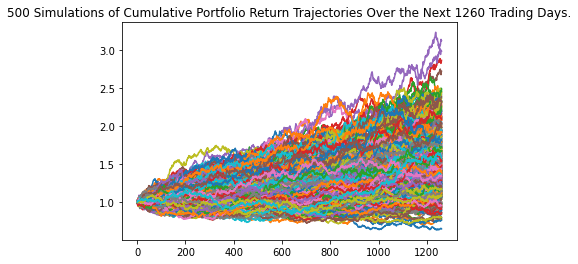

In [27]:
# Plot simulation outcomes
MC_five_year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

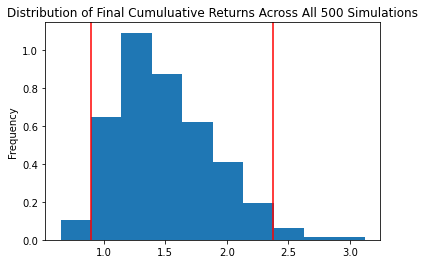

In [28]:
# Plot probability distribution and confidence intervals
MC_five_year.plot_distribution()

In [31]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_tbl = MC_five_year.summarize_cumulative_return()

# Print summary statistics
print(five_year_tbl)

count           500.000000
mean              1.503709
std               0.397829
min               0.647282
25%               1.207664
50%               1.426286
75%               1.738174
max               3.122749
95% CI Lower      0.896614
95% CI Upper      2.371390
Name: 1260, dtype: float64


In [32]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(five_year_tbl[8]*initial_investment,2)
ci_upper_five = round(five_year_tbl[9]*initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $17932.28 and $47427.8


### Ten Years Retirement Option

In [33]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[.40,.60],
    num_simulation=500,
    num_trading_days=252*10
)

In [34]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995384,0.995047,1.001911,0.999235,1.002851,1.006056,1.002173,0.985151,1.002146,0.994454,...,1.001107,0.998145,0.989937,1.000461,0.998757,0.991634,0.997406,1.007723,0.995645,0.996753
2,0.993813,0.994019,0.998054,0.992630,0.997132,1.011619,1.001483,0.990150,1.010501,0.990838,...,0.997741,0.993615,0.993270,0.998922,0.991843,0.986244,0.998408,1.017043,0.988656,0.984867
3,1.010290,0.980244,0.996755,0.995310,0.990237,1.001600,0.996118,0.990802,1.021709,0.991447,...,0.995605,0.991454,0.982553,1.008367,1.000739,0.981987,0.999151,1.017287,0.982761,0.986746
4,1.020633,0.993048,0.986615,0.993251,0.992431,1.008999,0.993607,0.995492,1.015728,0.994621,...,0.991678,0.993913,0.984757,0.997182,1.010937,0.976432,1.005525,1.025222,0.985916,0.978173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.361634,1.797815,2.135690,1.133463,2.342780,2.184358,1.670485,2.242881,1.789681,2.058498,...,2.230420,2.680028,3.351149,2.031408,1.234312,2.002901,1.313882,2.685303,1.962141,1.474320
2517,1.359062,1.815611,2.119449,1.130309,2.336952,2.198415,1.675426,2.224213,1.788867,2.073908,...,2.232782,2.701819,3.310919,2.049733,1.226880,2.005590,1.321629,2.665889,1.931387,1.451561
2518,1.355301,1.813667,2.126549,1.133613,2.330960,2.212497,1.678724,2.227586,1.793504,2.069610,...,2.237807,2.734785,3.335332,2.083569,1.222923,1.986512,1.297752,2.668032,1.916784,1.439175
2519,1.351232,1.845275,2.100827,1.138328,2.337479,2.195863,1.676626,2.227820,1.811018,2.044665,...,2.249784,2.689016,3.349103,2.072541,1.204924,1.971845,1.280367,2.671650,1.904016,1.424496


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

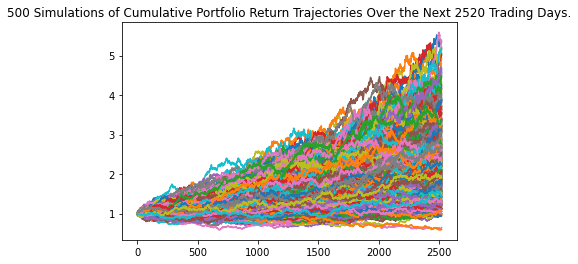

In [35]:
# Plot simulation outcomes
MC_ten_year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

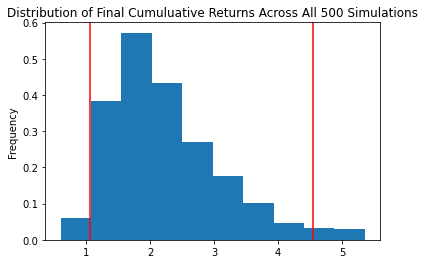

In [36]:
# Plot probability distribution and confidence intervals
MC_ten_year.plot_distribution()

In [37]:
# Fetch summary statistics from the Monte Carlo simulation results
ten_year_tbl = MC_ten_year.summarize_cumulative_return()

# Print summary statistics
print(ten_year_tbl)

count           500.000000
mean              2.254326
std               0.871922
min               0.598406
25%               1.641497
50%               2.048165
75%               2.699463
max               5.354167
95% CI Lower      1.057748
95% CI Upper      4.546511
Name: 2520, dtype: float64


In [39]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(ten_year_tbl[8]*initial_investment,2)
ci_upper_ten = round(ten_year_tbl[9]*initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $21154.97 and $90930.22
